<a href="https://colab.research.google.com/github/nehakanjamala/EczemaClassification-CNNModel/blob/code/eczema_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Directories found.


<ipython-input-4-d8683eecbe13>:27: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


79/79 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


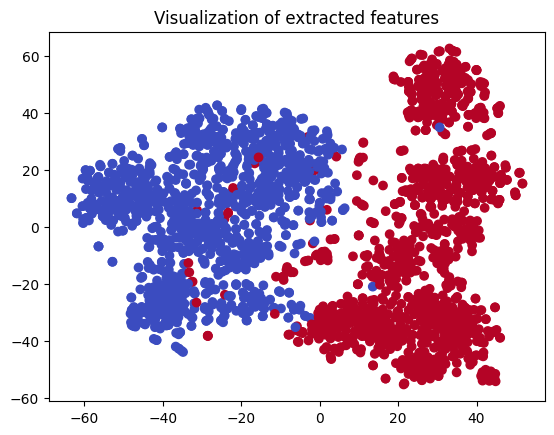

SVM Classification Accuracy: 0.9984
Class distribution: {0: 1554, 1: 1589}
Number of duplicate files: 3143


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# Define dataset paths
ECZEMA_PATH = "/content/drive/My Drive/furi/dataset/Eczema"
NORMAL_PATH = "/content/drive/My Drive/furi/dataset/Normal"

# Check if directories exist
if not os.path.exists(ECZEMA_PATH) or not os.path.exists(NORMAL_PATH):
    print("Error: Dataset paths do not exist. Check your Google Drive path.")
else:
    print("Directories found.")

# Load pre-trained MobileNetV2 for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Function to load and process images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
        labels.append(label)
    return images, labels

# Load dataset
eczema_images, eczema_labels = load_images_from_folder(ECZEMA_PATH, 0)
normal_images, normal_labels = load_images_from_folder(NORMAL_PATH, 1)

# Combine dataset
X_raw = np.array(eczema_images + normal_images)
y = np.array(eczema_labels + normal_labels)

# Split dataset before feature extraction
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=20, stratify=y)

# Extract features separately for train and test
X_train = base_model.predict(X_train_raw)
X_test = base_model.predict(X_test_raw)

# Visualize feature separability with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap='coolwarm')
plt.title("Visualization of extracted features")
plt.show()

# Train SVM classifier
clf = svm.SVC(kernel="rbf", C=10)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.4f}")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Check for duplicate filenames
train_files = set(os.listdir(ECZEMA_PATH)) | set(os.listdir(NORMAL_PATH))
test_files = set(os.listdir(ECZEMA_PATH)) | set(os.listdir(NORMAL_PATH))
intersection = train_files.intersection(test_files)
print(f"Number of duplicate files: {len(intersection)}")
